In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append(os.path.expanduser("~/clef/plantclef-2025/"))

In [3]:
from plantclef.spark import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/22 18:08:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/22 18:08:29 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [4]:
from pathlib import Path

home = Path.home()
subset_folder_name = "train_embeddings"
subset_train_path = home / f"shared/plantclef/data/embeddings/{subset_folder_name}/data"
df = spark.read.parquet(str(subset_train_path))

In [5]:
df.printSchema()
df.show(5)

root
 |-- image_name: string (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- cls_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- sample_id: integer (nullable = true)

+--------------------+----------+--------------------+---------+
|          image_name|species_id|       cls_embedding|sample_id|
+--------------------+----------+--------------------+---------+
|3a2c58a78ee93b471...|   1363472|[0.9020945, 0.016...|       15|
|0a0bf86d70307e8db...|   1361957|[-0.26025677, -0....|       15|
|7990901729be71186...|   1363472|[-0.1633016, -0.0...|       15|
|80257a4818f5955f9...|   1392612|[-0.7547744, 0.39...|       15|
|e13e476d0dc36ed7b...|   1360562|[0.14017674, 0.05...|       15|
+--------------------+----------+--------------------+---------+
only showing top 5 rows



In [6]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lit, row_number

id_map = df.withColumn("id", row_number().over(Window.orderBy(lit(0))) - 1).select("id", "image_name", "species_id")
id_map.show(5)

25/02/22 18:08:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/22 18:08:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/22 18:08:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/22 18:08:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/22 18:08:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---+--------------------+----------+
| id|          image_name|species_id|
+---+--------------------+----------+
|  0|3a2c58a78ee93b471...|   1363472|
|  1|0a0bf86d70307e8db...|   1361957|
|  2|7990901729be71186...|   1363472|
|  3|80257a4818f5955f9...|   1392612|
|  4|e13e476d0dc36ed7b...|   1360562|
+---+--------------------+----------+
only showing top 5 rows



In [7]:
id_map_name = "id_map"

out_folder = home / "scratch/plantclef/data/faiss"
out_folder.mkdir(parents=True, exist_ok=True)
id_map_path = out_folder / id_map_name

id_map.write.mode("overwrite").parquet(str(id_map_path))

25/02/22 18:09:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/22 18:09:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/22 18:09:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/22 18:09:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/22 18:09:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [8]:
import numpy as np
import faiss

In [15]:
%%time
embeddings = np.stack(df.orderBy("id").select("cls_embedding").rdd.map(lambda row: row[0]).collect()).astype("float32")
embeddings.shape

25/02/22 17:58:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/22 17:58:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/22 17:58:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/22 17:58:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/storage/scratch1/7/acheung46/plantclef/.venv/lib64/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/storage/scratch1/7/acheung46/plan

In [9]:
%%time
pandas_df = df.toPandas()
pandas_df.head()

CPU times: user 5.6 s, sys: 2.75 s, total: 8.35 s
Wall time: 20.5 s


image_name  species_id  \
0  3a2c58a78ee93b47147195bdefacec2054603748.jpg     1363472   
1  0a0bf86d70307e8db97ff5b9a8c47d1759a8bf16.jpg     1361957   
2  7990901729be7118653b777c348df0e7c0251222.jpg     1363472   
3  80257a4818f5955f9497f7233737db52d7ab1e51.jpg     1392612   
4  e13e476d0dc36ed7bb10813dd2a89d9fbf043943.jpg     1360562   

                                       cls_embedding  sample_id  
0  [0.9020945, 0.016531244, -1.2954441, 0.4327756...         15  
1  [-0.26025677, -0.60912925, -1.0938195, -0.7250...         15  
2  [-0.1633016, -0.084629074, 0.131258, -1.788052...         15  
3  [-0.7547744, 0.3905724, -0.81004167, 0.5461864...         15  
4  [0.14017674, 0.058774427, -0.7694211, 0.855001...         15

In [11]:
dim = np.array(df.select("cls_embedding").first()[0]).shape[0]
dim

768

In [12]:
index = faiss.IndexFlatL2(dim)

In [13]:
%%time
embeddings = np.stack(pandas_df["cls_embedding"].values).astype("float32")
embeddings.shape

CPU times: user 2.62 s, sys: 1.57 s, total: 4.19 s
Wall time: 4.21 s


(1408033, 768)

In [14]:
import time

t0 = time.time()
faiss.normalize_L2(embeddings)
index.add(embeddings)
print(f"Indexed {embeddings.shape[0]} embeddings in {time.time() - t0:.2f} seconds")


Indexed 1408033 embeddings in 1.95 seconds


In [15]:
index_path = out_folder / f"{subset_folder_name}.index"
faiss.write_index(index, str(index_path))

In [16]:
index = faiss.read_index(str(index_path))

In [17]:
def search(index, queries, top_k):
    t0 = time.time()
    faiss.normalize_L2(queries)
    d, i = index.search(queries, top_k)
    print(f"Found {top_k} nearest neighbors for {queries.shape[0]} queries in {time.time() - t0:.2f} seconds")
    return d, i

In [ ]:
for exp in range(0, 5):
    search(index, embeddings[:10**exp], 5)

Found 5 nearest neighbors for 1 queries in 1.60 seconds
Found 5 nearest neighbors for 10 queries in 1.64 seconds
Found 5 nearest neighbors for 100 queries in 4.17 seconds
Found 5 nearest neighbors for 1000 queries in 30.01 seconds
Found 5 nearest neighbors for 10000 queries in 297.12 seconds


In [19]:
d, i = search(index, embeddings[:10], 5)

Found 5 nearest neighbors for 10 queries in 1.71 seconds


In [20]:
d

array([[0.        , 0.79556966, 0.8011354 , 0.8255063 , 0.82876563],
       [0.        , 0.6387692 , 0.654473  , 0.6779758 , 0.68311745],
       [0.        , 0.7348903 , 0.75639284, 0.763025  , 0.786746  ],
       [0.        , 0.70972085, 0.7411541 , 0.7417434 , 0.75901157],
       [0.        , 0.32535285, 0.41609356, 0.43117273, 0.43273944],
       [0.        , 0.2706439 , 0.55746335, 0.576292  , 0.57877237],
       [0.        , 0.6280755 , 0.6592169 , 0.69121975, 0.71135   ],
       [0.        , 0.252515  , 0.27580565, 0.27751392, 0.291685  ],
       [0.        , 0.84208876, 0.8923166 , 0.95695996, 0.9684109 ],
       [0.        , 0.39451292, 0.4745834 , 0.49562874, 0.536248  ]],
      dtype=float32)

In [21]:
i

array([[      0, 1008262,  263901, 1373569,  399525],
       [      1,  465881,  103813, 1140298,  709127],
       [      2, 1370109,  863678,  210267,  214171],
       [      3,  426953,  203505,   17979,  341870],
       [      4,  691169,  188919, 1359724,  114516],
       [      5, 1084362,  192849,  352568,  327764],
       [      6, 1376664,  923293, 1315426, 1028011],
       [      7, 1262428,  786460,  114519,  796996],
       [      8,  638755, 1045448,  852163,  586081],
       [      9,  441124,  292299,  986370,  652843]])

In [19]:
species_ids_array = pandas_df["species_id"].values
pred_species = species_ids_array[i]
pred_species

array([[1363472, 1394677, 1363472, 1363472, 1394677],
       [1361957, 1361957, 1361957, 1361957, 1361957],
       [1363472, 1363472, 1363472, 1390963, 1363472],
       ...,
       [1357142, 1357142, 1357157, 1357157, 1357157],
       [1396018, 1396018, 1396018, 1396018, 1396018],
       [1392943, 1392943, 1392943, 1392943, 1356608]], dtype=int32)

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

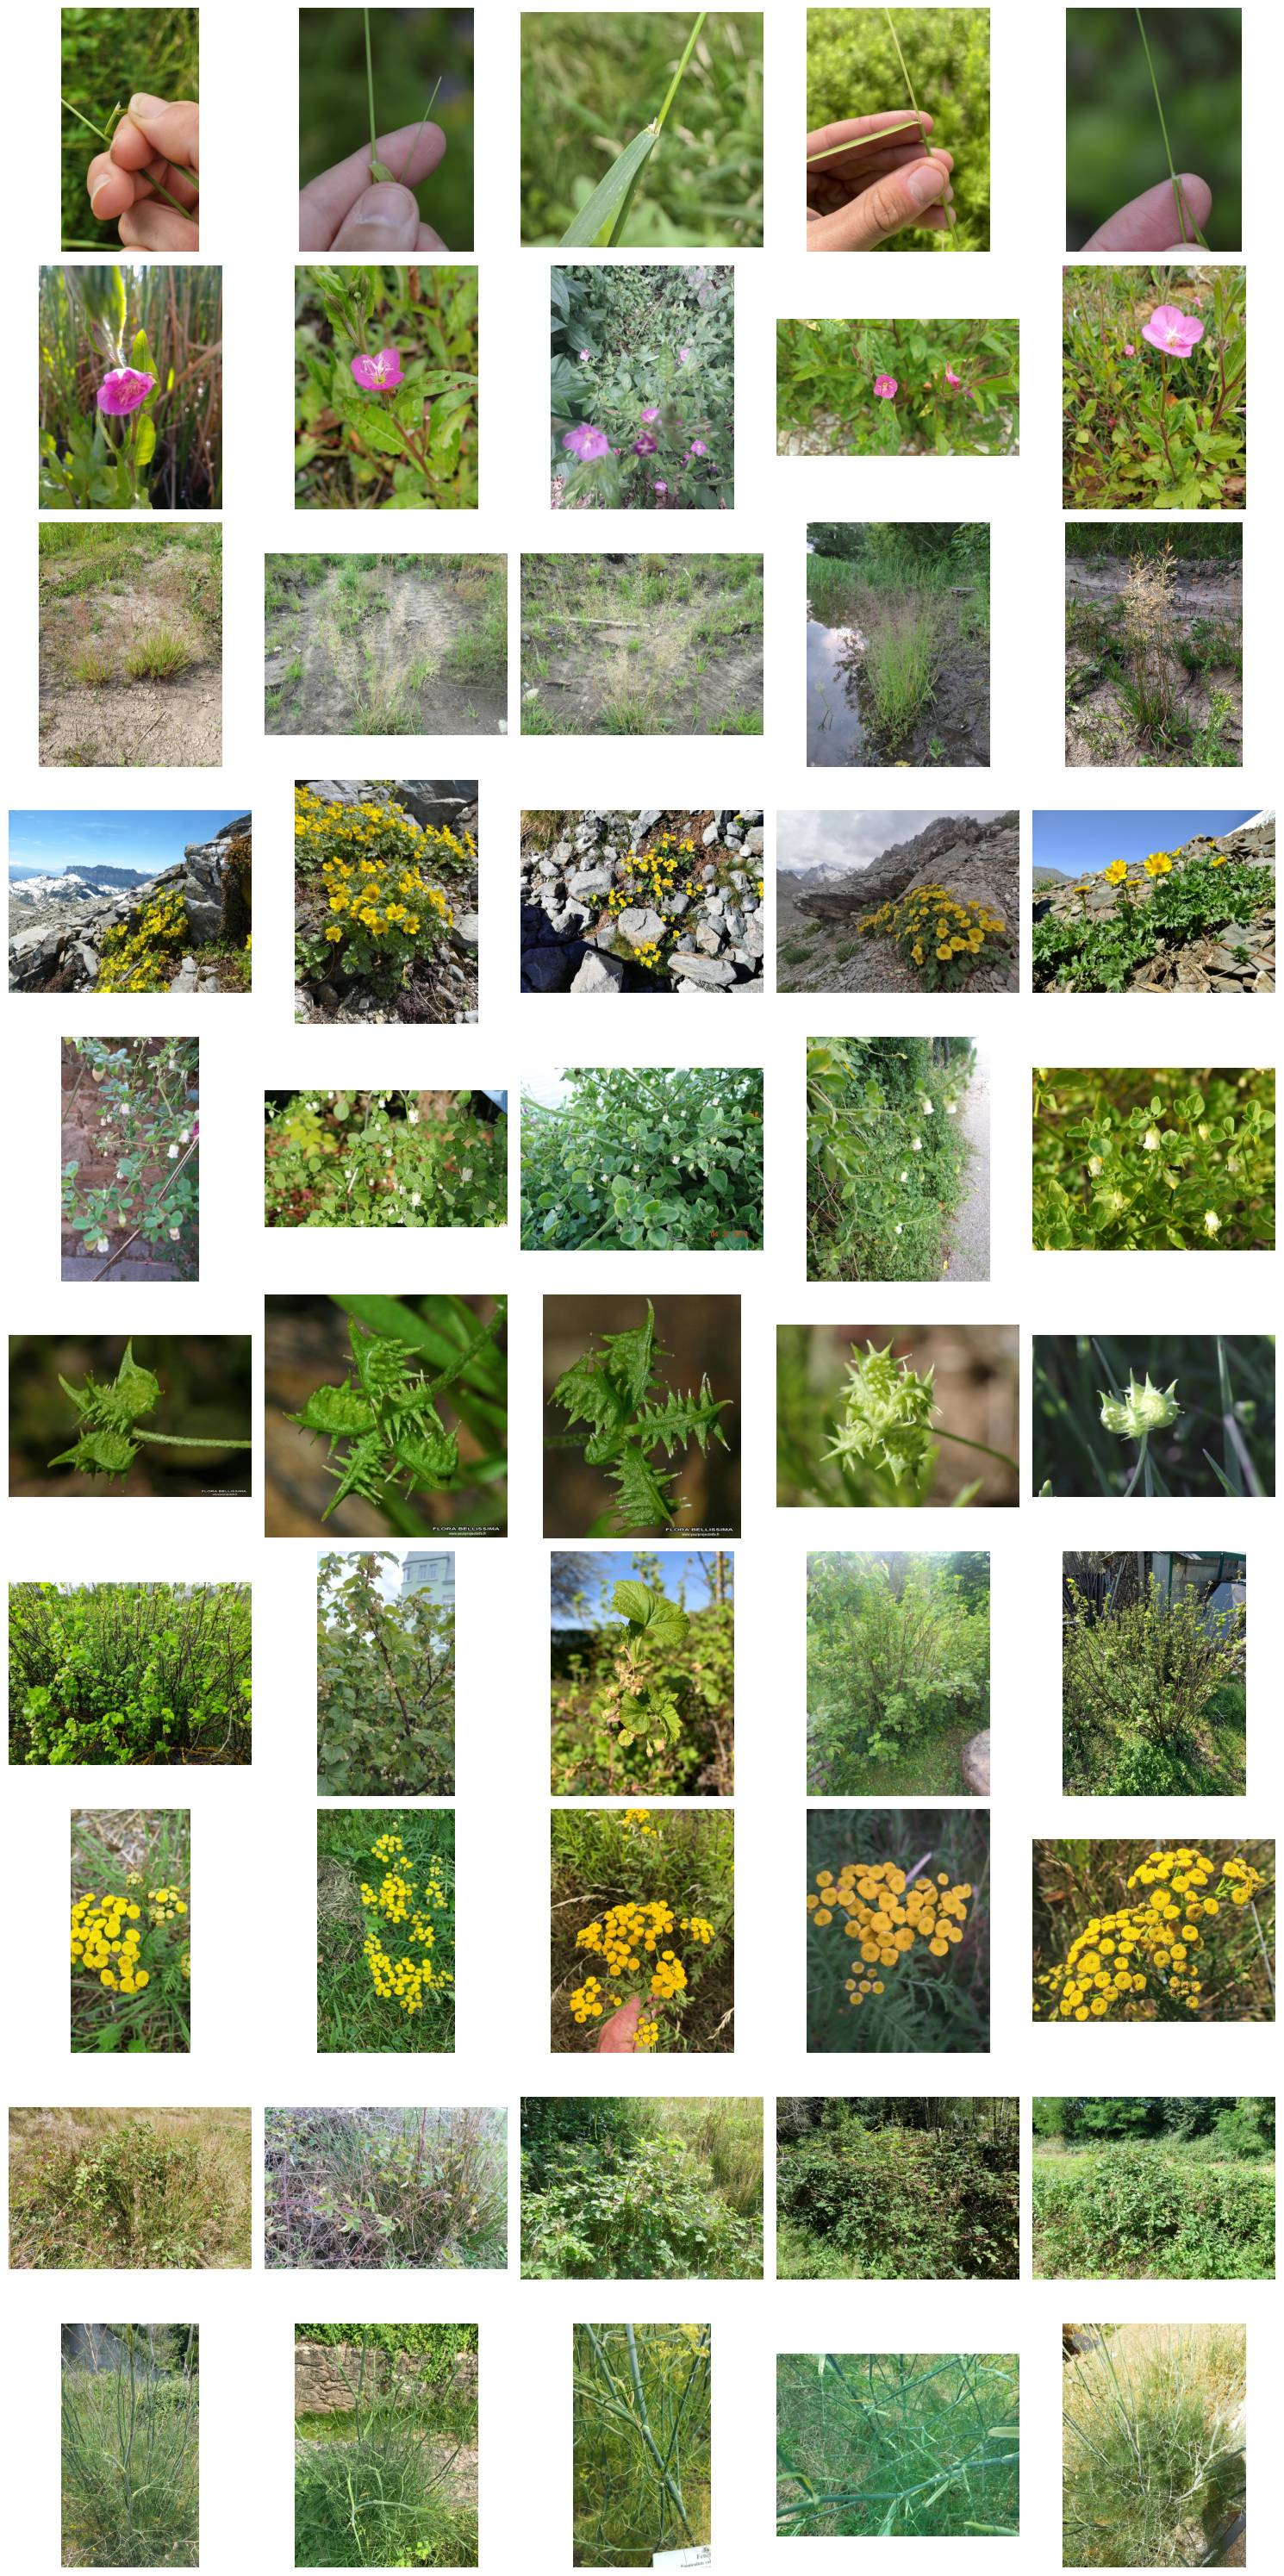

In [32]:
train_images_path = Path.home() / "shared/plantclef/data/train/PlantCLEF2024"
subdirs = ["train", "test", "val"]

fig, axes = plt.subplots(10, 5, figsize=(15, 30))

for row in range(10):
    for col in range(5):
        idx = i[row, col]
        species_id = pandas_df.loc[idx, "species_id"]
        image_name = pandas_df.loc[idx, "image_name"]
        
        img = None
        for subdir in subdirs:
            img_path = train_images_path / subdir / str(species_id) / image_name
            if img_path.exists():
                img = mpimg.imread(img_path)
                break
        axes[row, col].imshow(img)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()